# 📘 C1W2_L1: Naive Bayes Likelihoods – Teaching Version

In this workbook, our goal is to build a system that can predict whether a Tweet is positive or negative using the Naive Bayes approach. Like last week’s logistic regression, we’ll keep things simple and interpretable: no word order, no phrasing — just plain counts of which words appear.

But instead of learning weights through optimization (like logistic regression), this time we’ll build a model using **Bayes’ Theorem** and **word frequencies**.

You’ll see lots of overlap with Week 1’s bag-of-words approach — but the core *math* behind the prediction is different. Let’s dive in!

Unlike logistic regression last week, there’s no optimization or gradient descent here — just a lookup-based statistical model derived directly from the labeled data.

---

## 🧠 Quick Intro: What is Naive Bayes?
Naive Bayes is a simple yet powerful classification algorithm based on **Bayes’ Theorem**:

The “naive” assumption is that all words in a tweet are **conditionally independent**, given the sentiment label (whether the Tweet is Positive or Negative).

All we are doing is figuring out likelihood a word is positive or negative given that the Tweet is positive or negative. Once we have those likelihoods for all words in our dictionary we can predict whether new Tweets are positive or negative.

---

## 🔧 1. Setup & Downloads
Just like last week, before starting on the code examples, let's load some of the packages and the Tweet samples.

In [1]:
import nltk
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

---

## Import Python Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.corpus import twitter_samples, stopwords
from nltk.tokenize import TweetTokenizer
import string

In [5]:
import re
import string

def process_tweet(tweet):
    """Cleans tweet text."""
    tweet = tweet.lower()
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)  # Remove URLs
    tweet = re.sub(r'@\w+', '', tweet)                 # Remove @mentions
    tweet = re.sub(r'#', '', tweet)                    # Remove hashtags
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return tweet.split()

def count_tweets(freqs, tweets, labels):
    """Counts word frequencies in tweets by label (0 = neg, 1 = pos)."""
    for label, tweet in zip(labels, tweets):
        words = process_tweet(tweet)
        for word in words:
            pair = (word, label)
            freqs[pair] = freqs.get(pair, 0) + 1
    return freqs


## 📥 2. Toy Example
Like last week, let’s build a full, end-to-end Toy Example first to lock-in the concepts before moving on to the 10k Tweet example. We'll build a Naive Bayes model using 6 manually written Tweets.

We'll follow the following simple steps:
1. Hand create 6 Tweets and declard them positive or negative.
2. Pre-process the Tweets: clean, remove stop words
3. Count how often the remaining words occur in the positive and negative Tweets.
4. Calculate a ratio using these counts.


First let's familiarize ourselves with the data a bit.



In [6]:
# Step 1: Toy tweets and labels
toy_tweets = [
    "I love this product",           # pos
    "Very happy with my purchase",  # pos
    "Best thing ever!",             # pos
    "I hate this thing",            # neg
    "Terrible experience",          # neg
    "Horrible product"              # neg
]
toy_labels = [1, 1, 1, 0, 0, 0]  # 1 = positive, 0 = negative

# Step 2: Count word frequencies
freqs = count_tweets({}, toy_tweets, toy_labels)

# Step 3: Extract vocabulary and print it
vocab = set([pair[0] for pair in freqs])
V = len(vocab)

#Print the cleared extracted works from the Tweets
for i, tweet in enumerate(toy_tweets):
    print(f"Original: {tweet}")
    print(f"Cleaned:  {process_tweet(tweet)}\n")

#print the list of all extracted and the vocab count
print("📚 Vocabulary (sorted):")
print(sorted(vocab))
print(f"\n🔢 Vocabulary size: {V}")


Original: I love this product
Cleaned:  ['i', 'love', 'this', 'product']

Original: Very happy with my purchase
Cleaned:  ['very', 'happy', 'with', 'my', 'purchase']

Original: Best thing ever!
Cleaned:  ['best', 'thing', 'ever']

Original: I hate this thing
Cleaned:  ['i', 'hate', 'this', 'thing']

Original: Terrible experience
Cleaned:  ['terrible', 'experience']

Original: Horrible product
Cleaned:  ['horrible', 'product']

📚 Vocabulary (sorted):
['best', 'ever', 'experience', 'happy', 'hate', 'horrible', 'i', 'love', 'my', 'product', 'purchase', 'terrible', 'thing', 'this', 'very', 'with']

🔢 Vocabulary size: 16


And quickly, how many unique words from the dictionary are in both positive and negative.

In [7]:
# Total number of words in each class (positive & negative Tweets)
N_pos = sum([freqs.get((word, 1), 0) for word in vocab])
N_neg = sum([freqs.get((word, 0), 0) for word in vocab])

print(f"🟢 Total words in positive tweets: {N_pos}")
print(f"🔴 Total words in negative tweets: {N_neg}")


🟢 Total words in positive tweets: 12
🔴 Total words in negative tweets: 8


Figure out the proportion of positive to negative Tweets in the dataset.

In [8]:
#Determine the ratio of positive to negative Tweets. This log prior gives you the base bias of the classifier before any words are seen.
#In our example this is 0, since we have an equal number of positive and negative Tweets.

logprior = np.log(sum(toy_labels) / (len(toy_labels) - sum(toy_labels)))

print(f"\n⚖️ Log Prior: {logprior:.4f}")



⚖️ Log Prior: 0.0000


Now that we have taking a look at the data, let's calculate the Log-Liklihood of each word being positive or negative.

We'll produce a summary table that provides a crystal clear recap of output. Be sure to familiarize yourself with what we have generated and how it all links to the original 6 Tweets.

In [9]:
#Step 4: Compute Log-Likelihood for Each Word: This tells you how strongly each word tilts the prediction toward positive or negative.

loglikelihood = {}

for word in vocab:
    freq_pos = freqs.get((word, 1), 0)
    freq_neg = freqs.get((word, 0), 0)

    # Laplace smoothing
    p_w_pos = (freq_pos + 1) / (N_pos + V)
    p_w_neg = (freq_neg + 1) / (N_neg + V)

    # Log-likelihood ratio
    loglikelihood[word] = np.log(p_w_pos / p_w_neg)

    print(f"🔤 '{word}': log(P(word|pos)/P(word|neg)) = {loglikelihood[word]:.4f}")

import pandas as pd

# List to store each row
rows = []

# Loop through vocabulary
for word in sorted(vocab):
    freq_pos = freqs.get((word, 1), 0)
    freq_neg = freqs.get((word, 0), 0)

    p_w_pos = (freq_pos + 1) / (N_pos + V)
    p_w_neg = (freq_neg + 1) / (N_neg + V)

    llr = np.log(p_w_pos / p_w_neg)
    loglikelihood[word] = llr

    # Append row for DataFrame
    rows.append({
        "Word": word,
        "Pos Count": freq_pos,
        "Neg Count": freq_neg,
        "P(word|pos)": round(p_w_pos, 4),
        "P(word|neg)": round(p_w_neg, 4),
        "Log-Likelihood": round(llr, 4)
    })

# Create and display table
df_likelihood = pd.DataFrame(rows)
df_likelihood = df_likelihood.sort_values("Log-Likelihood", ascending=False)
df_likelihood.reset_index(drop=True, inplace=True)
df_likelihood


🔤 'love': log(P(word|pos)/P(word|neg)) = 0.5390
🔤 'happy': log(P(word|pos)/P(word|neg)) = 0.5390
🔤 'with': log(P(word|pos)/P(word|neg)) = 0.5390
🔤 'best': log(P(word|pos)/P(word|neg)) = 0.5390
🔤 'terrible': log(P(word|pos)/P(word|neg)) = -0.8473
🔤 'product': log(P(word|pos)/P(word|neg)) = -0.1542
🔤 'ever': log(P(word|pos)/P(word|neg)) = 0.5390
🔤 'this': log(P(word|pos)/P(word|neg)) = -0.1542
🔤 'hate': log(P(word|pos)/P(word|neg)) = -0.8473
🔤 'my': log(P(word|pos)/P(word|neg)) = 0.5390
🔤 'i': log(P(word|pos)/P(word|neg)) = -0.1542
🔤 'very': log(P(word|pos)/P(word|neg)) = 0.5390
🔤 'purchase': log(P(word|pos)/P(word|neg)) = 0.5390
🔤 'thing': log(P(word|pos)/P(word|neg)) = -0.1542
🔤 'horrible': log(P(word|pos)/P(word|neg)) = -0.8473
🔤 'experience': log(P(word|pos)/P(word|neg)) = -0.8473


,Word,Pos Count,Neg Count,P(word|pos),P(word|neg),Log-Likelihood
0,best,1,0,0.0714,0.0417,0.5390
1,ever,1,0,0.0714,0.0417,0.5390
2,happy,1,0,0.0714,0.0417,0.5390
3,love,1,0,0.0714,0.0417,0.5390
4,with,1,0,0.0714,0.0417,0.5390
5,very,1,0,0.0714,0.0417,0.5390
6,purchase,1,0,0.0714,0.0417,0.5390
7,my,1,0,0.0714,0.0417,0.5390
8,this,1,1,0.0714,0.0833,-0.1542
9,product,1,1,0.0714,0.0833,-0.1542


## Now that we have built the model, let's test it out on a new Tweet

In [10]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    words = process_tweet(tweet)
    score = logprior
    for word in words:
        if word in loglikelihood:
            score += loglikelihood[word]
    return score

test_tweet = "I hate this product"
score = naive_bayes_predict(test_tweet, logprior, loglikelihood)
sentiment = "Positive 😀" if score > 0 else "Negative 😞"
print(f"\n🧪 Test Tweet: '{test_tweet}' → Score: {score:.2f} → {sentiment}")



🧪 Test Tweet: 'I hate this product' → Score: -1.31 → Negative 😞


---

## 💬 3. On to the production example: Let's build Naive Bayes from the 10k Tweet sample



In [11]:
#Step 1: Load and take a look at the Teet data
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

print("Sample positive tweet:")
print(all_positive_tweets[0])

Sample positive tweet:
#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)


---

## 🧹 3a. Clean & Preprocess the Tweets

In [12]:
stopwords_english = stopwords.words('english')
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

def process_tweet(tweet):
    tokens = tokenizer.tokenize(tweet)
    clean = [word for word in tokens if word not in stopwords_english and word not in string.punctuation]
    return clean

# Try on a sample
process_tweet(all_negative_tweets[0])

['hopeless', 'tmr', ':(']

---

## 📊 3b. Count Word Frequencies

In [17]:
def count_tweets(freq_dict, tweets, labels):
    for label, tweet in zip(labels, tweets):
        for word in process_tweet(tweet):
            pair = (word, label)
            freq_dict[pair] = freq_dict.get(pair, 0) + 1
    return freq_dict


---

## 📐 4. Now let's "train" the Naive Bayes model

In [18]:
def train_naive_bayes(freqs, train_x, train_y):
    loglikelihood = {}
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)
    N_pos = N_neg = 0
    for pair in freqs:
        if pair[1] == 1:
            N_pos += freqs[pair]
        else:
            N_neg += freqs[pair]
    D = len(train_y)
    D_pos = sum(train_y)
    D_neg = D - D_pos
    logprior = np.log(D_pos / D_neg)
    for word in vocab:
        freq_pos = freqs.get((word, 1), 0)
        freq_neg = freqs.get((word, 0), 0)
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)
    return logprior, loglikelihood

---

## 🏗️ 4a. Build and Train the Model

In [19]:
train_x = all_positive_tweets[:4000] + all_negative_tweets[:4000]
train_y = np.append(np.ones(4000), np.zeros(4000))

freqs = count_tweets({}, train_x, train_y)
logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)

---

## 🔮 5. Let's Predict Some New Tweets

In [20]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    words = process_tweet(tweet)
    score = logprior
    for word in words:
        if word in loglikelihood:
            score += loglikelihood[word]
    return score

# Try a test tweet
tweet = "Today is awesome!"
print(f"Score: {naive_bayes_predict(tweet, logprior, loglikelihood):.2f}")

Score: 1.77


---

## 📊 6. Visualize Influential Words

/tmp/ipython-input-21-533482457.py:8: UserWarning: Glyph 12299 (\N{RIGHT DOUBLE ANGLE BRACKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-21-533482457.py:8: UserWarning: Glyph 65363 (\N{FULLWIDTH LATIN SMALL LETTER S}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-21-533482457.py:8: UserWarning: Glyph 65349 (\N{FULLWIDTH LATIN SMALL LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12299 (\N{RIGHT DOUBLE ANGLE BRACKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65363 (\N{FULLWIDTH LATIN SMALL LETTER S}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65349 (\N{FULLWIDTH LATIN SMALL 

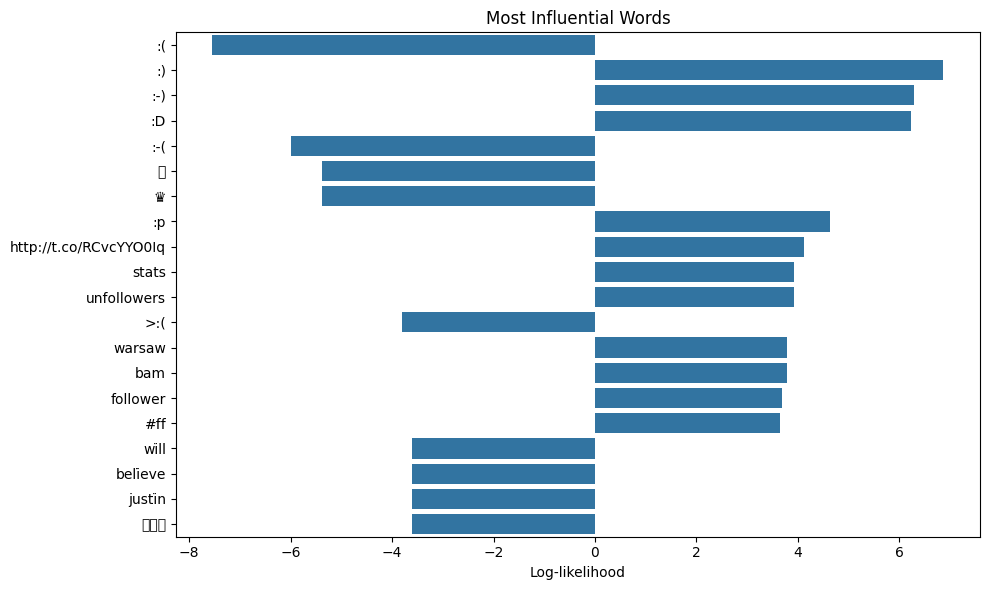

In [21]:
def plot_loglikelihoods(loglikelihood):
    top_words = sorted(loglikelihood.items(), key=lambda x: abs(x[1]), reverse=True)[:20]
    words, vals = zip(*top_words)
    plt.figure(figsize=(10,6))
    sns.barplot(x=list(vals), y=list(words))
    plt.title("Most Influential Words")
    plt.xlabel("Log-likelihood")
    plt.tight_layout()
    plt.show()

plot_loglikelihoods(loglikelihood)